# Quantum Teleportation + Noise

This notebook demonstrates quantum teleportation. We first use Qiskit's built-in simulators to test our quantum circuit, and then try it out on a real quantum computer.

## Contents

1. [Overview](#overview)    
2. [The Quantum Teleportation Protocol](#how)       
3. [Simulating the Teleportation Protocol](#simulating)   
    3.1 [How will we Test this Result on a Real Quantum Computer?](#testing)   
    3.2 [Using the Statevector Simulator](#simulating-sv)     
    3.3 [Using the QASM Simulator](#simulating-qs)  
4. [Understanding Quantum Teleportation](#understanding-qt)
5. [Teleportation on a Real Quantum Computer](#real_qc)    
    5.1 [IBM hardware and Deferred Measurement](#deferred-measurement)    
    5.2 [Executing](#executing)    
6. [References](#references)



## 1. Overview <a id='overview'></a>

Alice wants to send quantum information to Bob. Specifically, suppose she wants to send the qubit state
$\vert\psi\rangle = \alpha\vert0\rangle + \beta\vert1\rangle$. 
This entails passing on information about $\alpha$ and $\beta$ to Bob.

There exists a theorem in quantum mechanics which states that you cannot simply make an exact copy of an unknown quantum state. This is known as the no-cloning theorem. As a result of this we can see that Alice can't simply generate a copy of $\vert\psi\rangle$ and give the copy to Bob. We can only copy classical states (not superpositions).

However, by taking advantage of two classical bits and an entangled qubit pair, Alice can transfer her state $\vert\psi\rangle$ to Bob. We call this teleportation because, at the end, Bob will have $\vert\psi\rangle$ and Alice won't anymore.

## 2. The Quantum Teleportation Protocol <a id='how'></a>
To transfer a quantum bit, Alice and Bob must use a third party (Telamon) to send them an entangled qubit pair. Alice then performs some operations on her qubit, sends the results to Bob over a classical communication channel, and Bob then performs some operations on his end to receive Alice’s qubit.

![teleportation_doodle](images/tele1.jpg)

We will describe the steps on a quantum circuit below. Here, no qubits are actually ‘sent’, you’ll just have to imagine that part!

First we set up our session:

In [1]:
# Do the necessary imports
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import IBMQ, Aer, transpile, assemble
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.extensions import Initialize
from qiskit_textbook.tools import random_state, array_to_latex
# Do the necessary imports
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import IBMQ, Aer, transpile, assemble
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.extensions import Initialize
from qiskit_textbook.tools import random_state, array_to_latex
from qiskit import IBMQ, transpile
from qiskit import QuantumCircuit
from qiskit.providers.aer import AerSimulator
from qiskit.tools.visualization import plot_histogram
import qiskit as qk
from qiskit import IBMQ, BasicAer
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer
from qiskit.tools.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor, backend_overview
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, Aer
from qiskit import execute
from qiskit.tools.visualization import plot_histogram
import numpy as np
import matplotlib.pyplot as plt
from qiskit.ignis.mitigation.measurement import (complete_meas_cal,CompleteMeasFitter)
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error , phase_damping_error , amplitude_damping_error
from IPython.display import Image
from qiskit_textbook.tools import random_state, array_to_latex
from qiskit.visualization import plot_histogram, plot_bloch_multivector

# Do the necessary imports
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import IBMQ, Aer, transpile, assemble
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.extensions import Initialize
from qiskit_textbook.tools import random_state, array_to_latex
# Import libraries
import numpy as np
from numpy import pi as pi
from PIL import Image
from collections import OrderedDict
import matplotlib.pyplot as plt
import sys, random, ast, time
from pathlib import Path
import re
import pandas as pd
import inspect

# Import Qiskit
from qiskit import Aer, IBMQ
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.tools.monitor import job_monitor
from qiskit.tools.visualization import plot_histogram
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.aer.noise.errors import thermal_relaxation_error, pauli_error
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer import noise
from qiskit.tools.monitor import backend_monitor
from qiskit import QuantumCircuit, execute, Aer
from qiskit.visualization import plot_histogram
import qiskit.providers.aer.noise as noise

In [2]:
IBMQ.update_account()

mytoken = "e5e478e6c8add11a871103cddaae7d3e88325d6f97fd4dfcd7880c8feed140c4358f3dfc8014a346b3ea8b3f7a6771b15192ced8b096d632d22607b085556594" ## your token ##
IBMQ.save_account(mytoken)

provider = IBMQ.load_account()
backends = provider.backends()
backends

configrc.store_credentials:WARNING:2021-07-02 15:30:00,914: Credentials already present. Set overwrite=True to overwrite.


Found 1 credentials.
No credentials available for updating could be found. No action will be performed.
Warnings:
The stored account with url "https://auth.quantum-computing.ibm.com/api" is already an IBM Q Experience v2 account.


[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_athens') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_extended_stabilizer') fr

and create our quantum circuit:

In [3]:
## SETUP
# Protocol uses 3 qubits and 2 classical bits in 2 different registers

qr = QuantumRegister(3, name="q")    # Protocol uses 3 qubits
crz = ClassicalRegister(1, name="crz") # and 2 classical bits
crx = ClassicalRegister(1, name="crx") # in 2 different registers
teleportation_circuit = QuantumCircuit(qr, crz, crx)

#### Step 1
A third party, Telamon, creates an entangled pair of qubits and gives one to Bob and one to Alice.

The pair Telamon creates is a special pair called a Bell pair. In quantum circuit language, the way to create a Bell pair between two qubits is to first transfer one of them to the X-basis ($|+\rangle$ and $|-\rangle$) using a Hadamard gate, and then to apply a CNOT gate onto the other qubit controlled by the one in the X-basis. 

In [4]:
def create_bell_pair(qc, a, b):
    """Creates a bell pair in qc using qubits a & b"""
    qc.h(a) # Put qubit a into state |+>
    qc.cx(a,b) # CNOT with a as control and b as target

In [5]:
## SETUP
# Protocol uses 3 qubits and 2 classical bits in 2 different registers
qr = QuantumRegister(3, name="q")
crz, crx = ClassicalRegister(1, name="crz"), ClassicalRegister(1, name="crx")
teleportation_circuit = QuantumCircuit(qr, crz, crx)

## STEP 1
# In our case, Telamon entangles qubits q1 and q2
# Let's apply this to our circuit:
create_bell_pair(teleportation_circuit, 1, 2)
# And view the circuit so far:
teleportation_circuit.draw()

q_0: ──────────
       ┌───┐     
  q_1: ┤ H ├──■──
       └───┘┌─┴─┐
  q_2: ─────┤ X ├
            └───┘
crz: 1/══════════
                 
crx: 1/══════════

Let's say Alice owns $q_1$ and Bob owns $q_2$ after they part ways.

#### Step 2 

Alice applies a CNOT gate to $q_1$, controlled by $\vert\psi\rangle$ (the qubit she is trying to send Bob). Then Alice applies a Hadamard gate to $|\psi\rangle$. In our quantum circuit, the qubit ($|\psi\rangle$) Alice is trying to send is $q_0$:

In [6]:
def alice_gates(qc, psi, a):
    qc.cx(psi, a)
    qc.h(psi)

In [7]:
## SETUP
# Protocol uses 3 qubits and 2 classical bits in 2 different registers
qr = QuantumRegister(3, name="q")
crz, crx = ClassicalRegister(1, name="crz"), ClassicalRegister(1, name="crx")
teleportation_circuit = QuantumCircuit(qr, crz, crx)

## STEP 1
create_bell_pair(teleportation_circuit, 1, 2)

## STEP 2
teleportation_circuit.barrier() # Use barrier to separate steps
alice_gates(teleportation_circuit, 0, 1)
teleportation_circuit.draw()

░      ┌───┐
  q_0: ───────────░───■──┤ H ├
       ┌───┐      ░ ┌─┴─┐└───┘
  q_1: ┤ H ├──■───░─┤ X ├─────
       └───┘┌─┴─┐ ░ └───┘     
  q_2: ─────┤ X ├─░───────────
            └───┘ ░           
crz: 1/═══════════════════════
                              
crx: 1/═══════════════════════

#### Step 3

Next, Alice applies a measurement to both qubits that she owns, $q_1$ and $\vert\psi\rangle$, and stores this result in two classical bits. She then sends these two bits to Bob.

In [8]:
def measure_and_send(qc, a, b):
    """Measures qubits a & b and 'sends' the results to Bob"""
    qc.barrier()
    qc.measure(a,0)
    qc.measure(b,1)

In [9]:
## SETUP
# Protocol uses 3 qubits and 2 classical bits in 2 different registers
qr = QuantumRegister(3, name="q")
crz, crx = ClassicalRegister(1, name="crz"), ClassicalRegister(1, name="crx")
teleportation_circuit = QuantumCircuit(qr, crz, crx)

## STEP 1
create_bell_pair(teleportation_circuit, 1, 2)

## STEP 2
teleportation_circuit.barrier() # Use barrier to separate steps
alice_gates(teleportation_circuit, 0, 1)

## STEP 3
measure_and_send(teleportation_circuit, 0 ,1)
teleportation_circuit.draw()

░      ┌───┐ ░ ┌─┐   
  q_0: ───────────░───■──┤ H ├─░─┤M├───
       ┌───┐      ░ ┌─┴─┐└───┘ ░ └╥┘┌─┐
  q_1: ┤ H ├──■───░─┤ X ├──────░──╫─┤M├
       └───┘┌─┴─┐ ░ └───┘      ░  ║ └╥┘
  q_2: ─────┤ X ├─░────────────░──╫──╫─
            └───┘ ░            ░  ║  ║ 
crz: 1/═══════════════════════════╩══╬═
                                  0  ║ 
                                     ║ 
crx: 1/══════════════════════════════╩═
                                     0

#### Step 4

Bob, who already has the qubit $q_2$, then applies the following gates depending on the state of the classical bits:

00 $\rightarrow$ Do nothing

01 $\rightarrow$ Apply $X$ gate

10 $\rightarrow$ Apply $Z$ gate

11 $\rightarrow$ Apply $ZX$ gate

(*Note that this transfer of information is purely classical*.)

In [10]:
# This function takes a QuantumCircuit (qc), integer (qubit)
# and ClassicalRegisters (crz & crx) to decide which gates to apply
def bob_gates(qc, qubit, crz, crx):
    # Here we use c_if to control our gates with a classical
    # bit instead of a qubit
    qc.x(qubit).c_if(crx, 1) # Apply gates if the registers 
    qc.z(qubit).c_if(crz, 1) # are in the state '1'

In [11]:
## SETUP
# Protocol uses 3 qubits and 2 classical bits in 2 different registers
qr = QuantumRegister(3, name="q")
crz, crx = ClassicalRegister(1, name="crz"), ClassicalRegister(1, name="crx")
teleportation_circuit = QuantumCircuit(qr, crz, crx)

## STEP 1
create_bell_pair(teleportation_circuit, 1, 2)

## STEP 2
teleportation_circuit.barrier() # Use barrier to separate steps
alice_gates(teleportation_circuit, 0, 1)

## STEP 3
measure_and_send(teleportation_circuit, 0, 1)

## STEP 4
teleportation_circuit.barrier() # Use barrier to separate steps
bob_gates(teleportation_circuit, 2, crz, crx)
teleportation_circuit.draw()

░      ┌───┐ ░ ┌─┐    ░               
  q_0: ───────────░───■──┤ H ├─░─┤M├────░───────────────
       ┌───┐      ░ ┌─┴─┐└───┘ ░ └╥┘┌─┐ ░               
  q_1: ┤ H ├──■───░─┤ X ├──────░──╫─┤M├─░───────────────
       └───┘┌─┴─┐ ░ └───┘      ░  ║ └╥┘ ░  ┌───┐  ┌───┐ 
  q_2: ─────┤ X ├─░────────────░──╫──╫──░──┤ X ├──┤ Z ├─
            └───┘ ░            ░  ║  ║  ░  └─╥─┘  └─╥─┘ 
                                  ║  ║       ║   ┌──╨──┐
crz: 1/═══════════════════════════╩══╬═══════╬═══╡ = 1 ╞
                                  0  ║    ┌──╨──┐└─────┘
crx: 1/══════════════════════════════╩════╡ = 1 ╞═══════
                                     0    └─────┘

And voila! At the end of this protocol, Alice's qubit has now teleported to Bob.

## 3. Simulating the Teleportation Protocol <a id='simulating'></a>

### 3.1 How Will We Test the Protocol on a Quantum Computer? <a id='testing'></a>

In this notebook, we will initialize Alice's qubit in a random state $\vert\psi\rangle$ (`psi`). This state will be created using an `Initialize` gate on $|q_0\rangle$. In this chapter we use the function `random_state` to choose `psi` for us, but feel free to set `psi` to any qubit state you want.

<IPython.core.display.Math object>

/Users/rgomezlu/opt/anaconda3/envs/Qiskit/lib/python3.9/site-packages/qiskit/visualization/bloch.py:69: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  x_s, y_s, _ = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


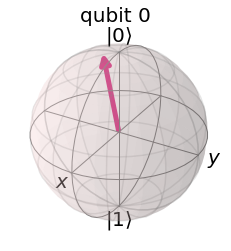

In [12]:
# Create random 1-qubit state
psi = random_state(1)

# Display it nicely
array_to_latex(psi, pretext="|\\psi\\rangle =")
# Show it on a Bloch sphere
plot_bloch_multivector(psi)

Let's create our initialization instruction to create $|\psi\rangle$ from the state $|0\rangle$:

In [13]:
init_gate = Initialize(psi)
init_gate.label = "init"

(`Initialize` is technically not a gate since it contains a reset operation, and so is not reversible. We call it an 'instruction' instead). If the quantum teleportation circuit works, then at the end of the circuit the qubit $|q_2\rangle$ will be in this state. We will check this using the statevector simulator.

### 3.2 Using the Statevector Simulator <a id='simulating-sv'></a>

We can use the statevector simulator to verify our qubit has been teleported.

In [14]:
## SETUP
qr = QuantumRegister(3, name="q")   # Protocol uses 3 qubits
crz = ClassicalRegister(1, name="crz") # and 2 classical registers
crx = ClassicalRegister(1, name="crx")
qc = QuantumCircuit(qr, crz, crx)

## STEP 0
# First, let's initialize Alice's q0
qc.append(init_gate, [0])
qc.barrier()

## STEP 1
# Now begins the teleportation protocol
create_bell_pair(qc, 1, 2)
qc.barrier()

## STEP 2
# Send q1 to Alice and q2 to Bob
alice_gates(qc, 0, 1)

## STEP 3
# Alice then sends her classical bits to Bob
measure_and_send(qc, 0, 1)

## STEP 4
# Bob decodes qubits
bob_gates(qc, 2, crz, crx)

# Display the circuit
qc.draw()

┌──────┐ ░            ░      ┌───┐ ░ ┌─┐                 
  q_0: ┤ init ├─░────────────░───■──┤ H ├─░─┤M├─────────────────
       └──────┘ ░ ┌───┐      ░ ┌─┴─┐└───┘ ░ └╥┘┌─┐              
  q_1: ─────────░─┤ H ├──■───░─┤ X ├──────░──╫─┤M├──────────────
                ░ └───┘┌─┴─┐ ░ └───┘      ░  ║ └╥┘ ┌───┐  ┌───┐ 
  q_2: ─────────░──────┤ X ├─░────────────░──╫──╫──┤ X ├──┤ Z ├─
                ░      └───┘ ░            ░  ║  ║  └─╥─┘  └─╥─┘ 
                                             ║  ║    ║   ┌──╨──┐
crz: 1/══════════════════════════════════════╩══╬════╬═══╡ = 1 ╞
                                             0  ║ ┌──╨──┐└─────┘
crx: 1/═════════════════════════════════════════╩═╡ = 1 ╞═══════
                                                0 └─────┘

We can see below, using our statevector simulator, that the state of $|q_2\rangle$ is the same as the state $|\psi\rangle$ we created above, while the states of $|q_0\rangle$ and $|q_1\rangle$ have been collapsed to either $|0\rangle$ or $|1\rangle$. The state $|\psi\rangle$ has been teleported from qubit 0 to qubit 2.

/Users/rgomezlu/opt/anaconda3/envs/Qiskit/lib/python3.9/site-packages/qiskit/visualization/bloch.py:69: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  x_s, y_s, _ = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


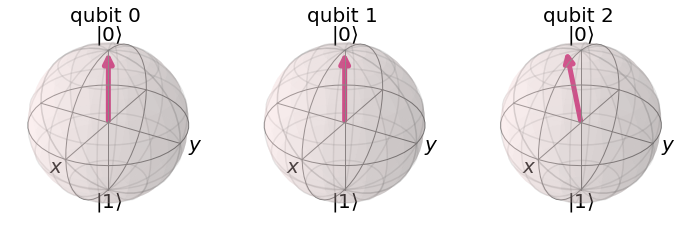

In [15]:
sv_sim = Aer.get_backend('statevector_simulator')
qobj = assemble(qc)
out_vector = sv_sim.run(qobj).result().get_statevector()
plot_bloch_multivector(out_vector)

You can run this cell a few times to make sure. You may notice that the qubits 0 & 1 change states, but qubit 2 is always in the state $|\psi\rangle$.

### 3.3 Using the QASM Simulator <a id='simulating-qs'></a>

Quantum teleportation is designed to send qubits between two parties. We do not have the hardware to demonstrate this, but we can demonstrate that the gates perform the correct transformations on a single quantum chip. Here we use the QASM simulator to simulate how we might test our protocol.

On a real quantum computer, we would not be able to sample the statevector, so if we wanted to check our teleportation circuit is working, we need to do things slightly differently. The `Initialize` instruction first performs a reset, setting our qubit to the state $|0\rangle$. It then applies gates to turn our $|0\rangle$ qubit into the state $|\psi\rangle$:

$$ |0\rangle \xrightarrow{\text{Initialize gates}} |\psi\rangle $$

Since all quantum gates are reversible, we can find the inverse of these gates using:

In [16]:
inverse_init_gate = init_gate.gates_to_uncompute()

This operation has the property:

$$ |\psi\rangle \xrightarrow{\text{Inverse Initialize gates}} |0\rangle $$

To prove the qubit $|q_0\rangle$ has been teleported to $|q_2\rangle$, if we do this inverse initialization on $|q_2\rangle$, we expect to measure $|0\rangle$ with certainty. We do this in the circuit below:

In [17]:
def new_bob_gates(qc, a, b, c):
    qc.cx(b, c)
    qc.cz(a, c)

In [18]:
## SETUP
qr = QuantumRegister(3, name="q")   # Protocol uses 3 qubits
#crz = ClassicalRegister(1, name="crz") # and 2 classical registers
#crx = ClassicalRegister(1, name="crx")
cr = ClassicalRegister(1, name="cr")
qc = QuantumCircuit(qr, cr)

## STEP 0
# First, let's initialize Alice's q0
qc.append(init_gate, [0])
qc.barrier()

## STEP 1
# Now begins the teleportation protocol
create_bell_pair(qc, 1, 2)
qc.barrier()

## STEP 2
# Send q1 to Alice and q2 to Bob
alice_gates(qc, 0, 1)

## STEP 3
# Alice then sends her classical bits to Bob
#measure_and_send(qc, 0, 1)

## STEP 4
# Bob decodes qubits
#bob_gates(qc, 2, crz, crx)
# Alice sends classical bits to Bob
new_bob_gates(qc, 0, 1, 2)

## STEP 5
# reverse the initialization process
qc.append(inverse_init_gate, [2])

# Display the circuit
qc.draw()

┌──────┐ ░            ░      ┌───┐                   
 q_0: ┤ init ├─░────────────░───■──┤ H ├─■─────────────────
      └──────┘ ░ ┌───┐      ░ ┌─┴─┐└───┘ │                 
 q_1: ─────────░─┤ H ├──■───░─┤ X ├──■───┼─────────────────
               ░ └───┘┌─┴─┐ ░ └───┘┌─┴─┐ │ ┌──────────────┐
 q_2: ─────────░──────┤ X ├─░──────┤ X ├─■─┤ disentangler ├
               ░      └───┘ ░      └───┘   └──────────────┘
cr: 1/═════════════════════════════════════════════════════

We can see the `inverse_init_gate` appearing, labelled 'disentangler' on the circuit diagram. Finally, we measure the third qubit and store the result in the third classical bit:

In [19]:
# Need to add a new ClassicalRegister
# to see the result
#cr_result = ClassicalRegister(1)
#qc.add_register(cr_result)
qc.measure(2,0)
qc.draw()

┌──────┐ ░            ░      ┌───┐                      
 q_0: ┤ init ├─░────────────░───■──┤ H ├─■────────────────────
      └──────┘ ░ ┌───┐      ░ ┌─┴─┐└───┘ │                    
 q_1: ─────────░─┤ H ├──■───░─┤ X ├──■───┼────────────────────
               ░ └───┘┌─┴─┐ ░ └───┘┌─┴─┐ │ ┌──────────────┐┌─┐
 q_2: ─────────░──────┤ X ├─░──────┤ X ├─■─┤ disentangler ├┤M├
               ░      └───┘ ░      └───┘   └──────────────┘└╥┘
cr: 1/══════════════════════════════════════════════════════╩═
                                                            0

and we run our experiment:

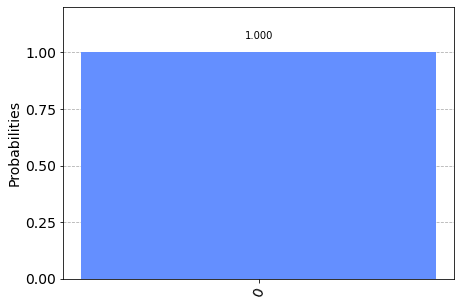

In [20]:
qasm_sim = Aer.get_backend('qasm_simulator')
t_qc = transpile(qc, qasm_sim)
qobj = assemble(t_qc)
counts = qasm_sim.run(qobj).result().get_counts()
plot_histogram(counts)

We can see we have a 100% chance of measuring $q_2$ (the leftmost bit in the string) in the state $|0\rangle$. This is the expected result, and indicates the teleportation protocol has worked properly.

## Once we have the circuit we build the Noise models and apply them to the circuit

In [21]:
# Some useful functions
def getSQGateExecutionTime(gate, backend, names):
    '''Returns the average execution time of the single-qubit type gates we are interested in.'''
    # Single qubit gates
    s = [0]*len(names)
    for i in range(0,len(names)):
        #s[i] = backend.properties().gate_length(gate, [i])
        s[i] = backend.properties().gate_length(gate, [i])
    return (np.mean(s)*(10**9))
#backend = provider.backend.ibmq_16_melbourne
#backend = provider.backend.ibmq_lima
backend = provider.backend.ibmq_belem
#backend = provider.backend.ibmqx2
print(backend.properties().gate_length('cx',(0,1)))
print(backend.properties().readout_length(2))
names = [0, 1, 2] # The single-qubit gates that we are interested in
gate = "id"
s = getSQGateExecutionTime(gate,backend,names)
print(s)
print(backend.properties().gate_length("x",0)*(10**9))
def getDecoherenceTimes(data):
    '''Returns the thermal relaxation time T1 and the qubit dephasing time T2, as given by IBMQ.'''
    t1er = data["T1 (us)"].tolist()
    
    t2er = data["T2 (us)"].tolist()
    

    #for i in range(0, len(t1er)):
        #t1er[i] = float(t1er[i] + "e3")
        #t2er[i] = float(t2er[i] + "e3") ##Check order of magnitude????

    T1s = np.array(t1er)
    T2s = np.array(t2er)
    
    # Check for error in IBMQ's measurements (i.e it must always be T2 <= 2T1)
    c = 0
    for i in range(0,len(T1s)):
        if (T2s[i] > 2*T1s[i]):
            c = 1
            print("ERROR: incompatible decay rates - Qubit Q" + str(i) + ", T2 =", T2s[i], "and T1 =", T1s[i])
    if (c == 0):
        print(r'Checking decoherence times: all ok')

    return T1s*1000,T2s*1000
def getSQGateExecutionTime(gate, backend, names):
    '''Returns the average execution time of the single-qubit type gates we are interested in.'''
    # Single qubit gates
    s = [0]*len(names)
    for i in range(0,len(names)):
        s[i] = backend.properties().gate_length(gate, [i])

    return (np.mean(s)*(10**9))
def getTQGateExecutionTime(gate, backend, graph):
    '''Returns the average execution time of the two-qubit type gates in the circuit.'''
    # Two qubit gates

    t = [0]*len(graph)
    for i in range(0,len(graph)):
        t[i] = backend.properties().gate_length('cx', graph[i])

    return (np.mean(t)*(10**9))
def getMeasExecutionTime(backend, names):
    '''Returns the average measure time of the single-qubit we are interested in.'''
    # Single qubit gates
    s = [0]*len(names)
    for i in range(0,len(names)):
        s[i] = backend.properties().readout_length(i)
    return (np.mean(s))
def getSQGateErrorAvg(gate, backend, names):
    '''Returns the average execution time of the single-qubit type gates we are interested in.'''
    # Single qubit gates
    s = [0]*len(names)
    for i in range(0,len(names)):
        s[i] = backend.properties().gate_error(gate, [i])

    return (np.mean(s))
def getTQGateErrorAvg(gate, backend, graph):
    '''Returns the average execution time of the two-qubit type gates in the circuit.'''
    # Two qubit gates

    t = [0]*len(graph)
    for i in range(0,len(graph)):
        t[i] = backend.properties().gate_error('cx', graph[i])

    return (np.mean(t))
def getMeasErorrAvg(backend, names):
    '''Returns the average measure time of the single-qubit we are interested in.'''
    # Single qubit gates
    s = [0]*len(names)
    for i in range(0,len(names)):
        s[i] = backend.properties().readout_error(i)
    return (np.mean(s))

8.106666666666666e-07
5.35111111111111e-06
35.55555555555556
35.55555555555556


## DEPOLARIZING CHANNEL USING ONLY ONE PROPERTY OF THE QUBIT

In [22]:
# Create the error channels

prob_1 = backend.properties().gate_error('x',1)
prob_2 = backend.properties().gate_error('cx',(0,1))
p_error = backend.properties().readout_error(0)
print(backend.properties().readout_length(0))

# Depolarizing quantum errors
error_1 = noise.depolarizing_error(prob_1, 1)
error_2 = noise.depolarizing_error(prob_2, 2)


# State preparation and Measurement (SPAM) Channel

bit_flip = pauli_error([('X', p_error), ('I', 1 - p_error)])



#time_reset = 1000  # 1 microsecond
#time_measure = 1000 # 1 microsecond
noise_thermal = NoiseModel()

noise_thermal.add_all_qubit_quantum_error(bit_flip, "reset")
noise_thermal.add_all_qubit_quantum_error(bit_flip, "measure")
noise_thermal.add_all_qubit_quantum_error(error_1, ["h","x","z"])
noise_thermal.add_all_qubit_quantum_error(error_2, "cx")





5.35111111111111e-06


In [23]:
## We execute the circuit with this noise model
simulate = execute(qc, backend = Aer.get_backend("qasm_simulator"), basis_gates=noise_thermal.basis_gates, 
                               noise_model=noise_thermal, shots=1024).result()
counts1 = simulate.get_counts()
plot_histogram(counts1)
print(counts1)

{'1': 64, '0': 960}


## DEPOLARIZING CHANNEL USING THE PROPERTIES OF EACH QUBIT

In [24]:
# Create the error channels

prob_10 = backend.properties().gate_error('x',0)
prob_11 = backend.properties().gate_error('x',1)
prob_12 = backend.properties().gate_error('x',2)

prob_20 = backend.properties().gate_error('cx',(0,1))
prob_21 = backend.properties().gate_error('cx',(1,2))
p_error0 = backend.properties().readout_error(0)
p_error1 = backend.properties().readout_error(1)
p_error2 = backend.properties().readout_error(2)
print(backend.properties().readout_length(0))

# Depolarizing quantum errors
error_10 = noise.depolarizing_error(prob_10, 1)
error_11 = noise.depolarizing_error(prob_11, 1)
error_12 = noise.depolarizing_error(prob_12, 1)
error_20 = noise.depolarizing_error(prob_20, 2)
error_21 = noise.depolarizing_error(prob_20, 2)


# State preparation and Measurement (SPAM) Channel

bit_flip0 = pauli_error([('X', p_error0), ('I', 1 - p_error0)])
bit_flip1 = pauli_error([('X', p_error1), ('I', 1 - p_error1)])
bit_flip2 = pauli_error([('X', p_error2), ('I', 1 - p_error2)])

noise_thermal = NoiseModel()

noise_thermal.add_quantum_error(bit_flip0, "reset",[0])
noise_thermal.add_quantum_error(bit_flip1, "reset",[1])
noise_thermal.add_quantum_error(bit_flip2, "reset",[2])
noise_thermal.add_quantum_error(bit_flip0, "measure",[0])
noise_thermal.add_quantum_error(bit_flip1, "measure",[1])
noise_thermal.add_quantum_error(bit_flip2, "measure",[2])
noise_thermal.add_quantum_error(error_10, ["h","x","z"],[0])
noise_thermal.add_quantum_error(error_11, ["h","x","z"],[1])
noise_thermal.add_quantum_error(error_12, ["h","x","z"],[2])

noise_thermal.add_quantum_error(error_20, "cx",(0,1))
noise_thermal.add_quantum_error(error_20, "cx",(1,2))

5.35111111111111e-06


{'1': 68, '0': 956}


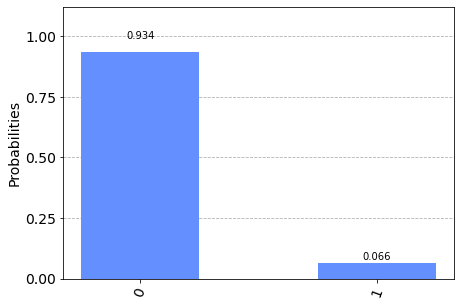

In [25]:
## We run the model
simulate = execute(qc, backend = Aer.get_backend("qasm_simulator"), basis_gates=noise_thermal.basis_gates, 
                               noise_model=noise_thermal, shots=1024).result()
counts2 = simulate.get_counts()
print(counts2)

plot_histogram(counts2)

## DEPOLARIZING CHANNEL USING AVERAGED PROPERTIES OF THE QUBITS

In [26]:
# Create the error channels

graph = [[0,1], [1,2]] # The two-qubit gates that we are interested in
names = [0, 1, 2] # The single-qubit gates that we are interested in
# Instruction times (in nanoseconds)
prob_1 = getSQGateErrorAvg('x', backend, names)

prob_2 = getTQGateErrorAvg('cx', backend, graph)
p_error = getMeasErorrAvg(backend, names)



# Depolarizing quantum errors
error_1 = noise.depolarizing_error(prob_1, 1)
error_2 = noise.depolarizing_error(prob_2, 2)


# State preparation and Measurement (SPAM) Channel

bit_flip = pauli_error([('X', p_error), ('I', 1 - p_error)])



#time_reset = 1000  # 1 microsecond
#time_measure = 1000 # 1 microsecond
noise_thermal = NoiseModel()

noise_thermal.add_all_qubit_quantum_error(bit_flip, "reset")
noise_thermal.add_all_qubit_quantum_error(bit_flip, "measure")
noise_thermal.add_all_qubit_quantum_error(error_1, ["h","x","z"])
noise_thermal.add_all_qubit_quantum_error(error_2, "cx")

{'1': 53, '0': 971}


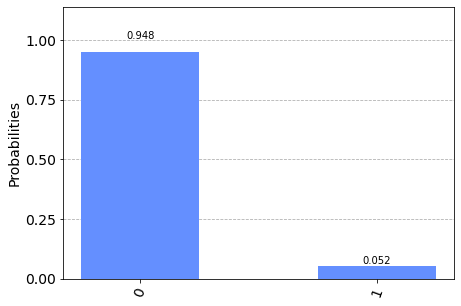

In [27]:
## We run the model
simulate = execute(qc, backend = Aer.get_backend("qasm_simulator"), basis_gates=noise_thermal.basis_gates, 
                               noise_model=noise_thermal, shots=1024).result()
counts3 = simulate.get_counts()
print(counts3)
plot_histogram(counts3)

## DEPOLARIZING + THERMAL RELAXATION CHANNELS USING AVERAGED PROPERTIES OF THE QUBITS FOR THE DEPOLARIZING CHANNEL

In [28]:
# Create the error channels
 
prob_10 = backend.properties().gate_error('x',0)
prob_11 = backend.properties().gate_error('x',1)
prob_12 = backend.properties().gate_error('x',2)

prob_20 = backend.properties().gate_error('cx',(0,1))
prob_21 = backend.properties().gate_error('cx',(1,2))
p_error0 = backend.properties().readout_error(0)
p_error1 = backend.properties().readout_error(1)
p_error2 = backend.properties().readout_error(2)
print(backend.properties().readout_length(0))

###
prob_1 = getSQGateErrorAvg('x', backend, names)

prob_2 = getTQGateErrorAvg('cx', backend, graph)
p_error = getMeasErorrAvg(backend, names)

# Depolarizing quantum errors
error_10 = noise.depolarizing_error(prob_10, 1)
error_11 = noise.depolarizing_error(prob_11, 1)
error_12 = noise.depolarizing_error(prob_12, 1)
error_20 = noise.depolarizing_error(prob_20, 2)
error_21 = noise.depolarizing_error(prob_20, 2)
error_1 = noise.depolarizing_error(prob_1, 1)
error_2 = noise.depolarizing_error(prob_2, 1)


# State preparation and Measurement (SPAM) Channel

bit_flip =  pauli_error([('X', p_error), ('I', 1 - p_error)])
bit_flip0 = pauli_error([('X', p_error0), ('I', 1 - p_error0)])
bit_flip1 = pauli_error([('X', p_error1), ('I', 1 - p_error1)])
bit_flip2 = pauli_error([('X', p_error2), ('I', 1 - p_error2)])

# Thermal Relaxation Channel
#data = pd.read_csv("/Users/rgomezlu/Google_Drive/Màster/TFM/Programació/qnoisecomb-master/ibmq_16_melbourne_calibrations.csv")
data = pd.read_csv("/Users/rgomezlu/Google_Drive/Màster/TFM/Programació/qnoisecomb-master/ibmq_belem_calibrations.csv")
T1s,T2s = getDecoherenceTimes(data)
# T1 and T2 values for qubits 0-3
#T1s = np.random.normal(50e3, 10e3, 4) # Sampled from normal distribution mean 50 microsec
#T2s = np.random.normal(70e3, 10e3, 4)  # Sampled from normal distribution mean 50 microsec

# Truncate random T2s <= T1s
#T2s = np.array([min(T2s[j], 2 * T1s[j]) for j in range(4)])
graph = [[0,1], [1,2]] # The two-qubit gates that we are interested in
names = [0, 1, 2] # The single-qubit gates that we are interested in
# Instruction times (in nanoseconds)
time_u1 = 10 # virtual gate
time_x = getSQGateExecutionTime('x', backend, names) # Average of all u2 times
#time_u3 = getSQGateExecutionTime('x', backend, gates) # Average of all u3 times
time_cx = getTQGateExecutionTime('cx', backend, graph) # Average of all cx times
time_reset = getMeasExecutionTime(backend, names)# Average of all meas times
time_measure = getMeasExecutionTime(backend, names)# Average of reset times 
print(time_measure)
#time_reset = 1000  # 1 microsecond
#time_measure = 1000 # 1 microsecond

# QuantumError objects

errors_measure = [thermal_relaxation_error(t1, t2, time_measure)
                    for t1, t2 in zip(T1s, T2s)]
print(errors_measure[0])
for i in range(len(errors_measure)):
    errors_measure[i] = bit_flip.compose(errors_measure[i])
errors_x  = [thermal_relaxation_error(t1, t2, time_x)
             for t1, t2 in zip(T1s, T2s)]

for i in range(len(errors_x)):
    errors_x[i] = error_1.compose(errors_x[i])
print(errors_x[0])
#print((error_2.compose(thermal_relaxation_error(T1s[0], T2s[0], time_cx))).expand(error_2.compose(
                 #thermal_relaxation_error(T1s[2], T2s[2], time_cx))))

errors_cx = [[thermal_relaxation_error(t1a, t2a, time_cx).expand(
                 thermal_relaxation_error(t1b, t2b, time_cx))
                  for t1a, t2a in zip(T1s, T2s)]
                   for t1b, t2b in zip(T1s, T2s)]



noise_thermal = NoiseModel()

for j in range(len(T1s)):
        noise_thermal.add_quantum_error(errors_measure[j], "reset", [j])
        noise_thermal.add_quantum_error(errors_measure[j], "measure", [j])
        #noise_thermal.add_quantum_error(errors_u1[j], "u1", [j])
        noise_thermal.add_quantum_error(errors_x[j], "p", [j])
        noise_thermal.add_quantum_error(errors_x[j], "h", [j])
        noise_thermal.add_quantum_error(errors_x[j], "x", [j])
        noise_thermal.add_quantum_error(errors_x[j], "z", [j])
        #noise_thermal.add_quantum_error(errors_u2[j], "u2", [j])
        #noise_thermal.add_quantum_error(errors_u3[j], "u3", [j])
        noise_thermal.add_quantum_error(errors_x[j], "u", [j])
        
        for k in range(len(T1s)):
            noise_thermal.add_quantum_error(errors_cx[j][k], "cx", [j, k])


        
print(noise_thermal)

5.35111111111111e-06
Checking decoherence times: all ok
5.35111111111111e-06
QuantumError on 1 qubits. Noise circuits:
  P(0) = 1.0, QasmQobjInstructions = [[{'name': 'id', 'qubits': [0]}]
QuantumError on 1 qubits. Noise circuits:
  P(0) = 1.0, QasmQobjInstructions = [[{'name': 'kraus', 'qubits': [0], 'params': [array([[-0.99985018+0.j,  0.        +0.j],
       [ 0.        +0.j, -0.99963315+0.j]]), array([[-0.01211744+0.j,  0.        +0.j],
       [ 0.        +0.j,  0.01212007+0.j]]), array([[0.       +0.j, 0.       +0.j],
       [0.0123604+0.j, 0.       +0.j]]), array([[0.        +0.j, 0.02422107+0.j],
       [0.        +0.j, 0.        +0.j]])]}]
NoiseModel:
  Basis gates: ['cx', 'h', 'id', 'p', 'u', 'u3', 'x', 'z']
  Instructions with noise: ['x', 'h', 'reset', 'measure', 'cx', 'p', 'z', 'u']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('reset', [0]), ('reset', [1]), ('reset', [2]), ('reset', [3]), ('reset', [4]), ('measure', [0]), ('measure', [1]), ('measure', [2]

{'1': 61, '0': 963}


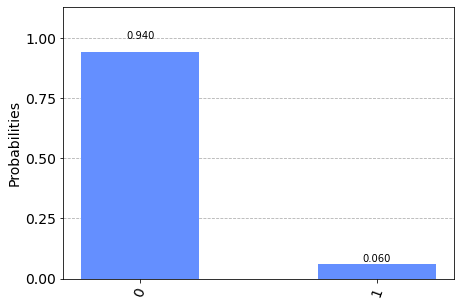

In [29]:
simulate = execute(qc, backend = Aer.get_backend("qasm_simulator"), basis_gates=noise_thermal.basis_gates, 
                               noise_model=noise_thermal, shots=1024).result()
counts4 = simulate.get_counts()
print(counts4)
plot_histogram(counts4)

## NOW WE PLOT THE DIFFERENT HISTOGRAMS AND COMPARE THE PROBABILITY DISTRIBUTIONS USING HELLINGER DISTANCE

In [30]:
## We define Hellinger distance
def hellingerDistance(p, q):
    '''Calculate the Hellinger distance between two probability distributions, P and Q. P and Q are given as simple 
    arrays containing the probabilities p[i] and q[i]. IMPORTANT: the probability arrays have to be ordered in the 
    same way.'''
    sum = 0
    for i in range (0, len(p)):
        sum = sum + (np.sqrt(p[i]) - np.sqrt(q[i]))**2
        
    h = (1/np.sqrt(2))*np.sqrt(sum)
        
    return h
## We define a function to get the probabilities
def getProbabilities(dct,N):
    p = []
    p.append(dct["0 0 0"]/N)
    
    p.append(dct["0 0 1"]/N)
    
    p.append(dct["0 1 0"]/N)
    
    p.append(dct["0 1 1"]/N)
    p.append(dct["1 0 0"]/N)
    p.append(dct["1 0 1"]/N)
    p.append(dct["1 1 0"]/N)
    p.append(dct["1 1 1"]/N)
    
    
    return p
def getProbabilities2(dct,N):
    p = []
    p.append(dct["0"]/N)
    p.append(dct["1"]/N)
    return p



In [31]:
pe1 = getProbabilities2(counts1,1024)
pe2 = getProbabilities2(counts2,1024)
pe3 = getProbabilities2(counts3,1024)
pe4 = getProbabilities2(counts4,1024)
PS = [pe1,pe2,pe3,pe4]
#path = "/Users/rgomezlu/Google_Drive/Màster/TFM/Programació/jobs/yorktown/Tele/bar-chart.csv"
#data = pd.read_csv("/Users/rgomezlu/Google_Drive/Màster/TFM/Programació/jobs/yorktown/Tele/bar-chart.csv")

path = "/Users/rgomezlu/Google_Drive/Màster/TFM/Programació/jobs/belem/Tele/bar-chart.csv"
data = pd.read_csv("/Users/rgomezlu/Google_Drive/Màster/TFM/Programació/jobs/belem/Tele/bar-chart.csv")

keys = ['0 0 0', '0 0 1', '0 1 0', '0 1 1', '1 0 0', '1 0 1', '1 1 0', '1 1 1']
values = data["Frequency"]
print(values)
v0 =sum(data["Frequency"][:4])
v1 =sum(data["Frequency"][4:])
valuesT =[v0,v1]
keys2 = ['0','1']
dct = dict(zip(keys,values))
dct2 = dict(zip(keys2,valuesT))
print(dct2)


pee = getProbabilities(dct,1024)
pee1=[sum(pee[:4]),sum(pee[4:])]
h=[]
for x in PS:
    h.append(hellingerDistance(pee1,x))
print(h)

0    216
1    183
2    176
3    161
4     74
5     84
6     55
7     75
Name: Frequency, dtype: int64
{'0': 736, '1': 288}
[0.21574784469906355, 0.2101871799306072, 0.23192289763920404, 0.22002322628597107]


In [32]:
#path = "/Users/rgomezlu/Google_Drive/Màster/TFM/Programació/jobs/yorktown/Tele/bar-chart-2.csv"
#data = pd.read_csv("/Users/rgomezlu/Google_Drive/Màster/TFM/Programació/jobs/yorktown/Tele/bar-chart-2.csv")

#path = "/Users/rgomezlu/Google_Drive/Màster/TFM/Programació/jobs/belem/Tele/bar-chart-2.csv"
#data = pd.read_csv("/Users/rgomezlu/Google_Drive/Màster/TFM/Programació/jobs/belem/bar-chart-2.csv")

keys = ['0 0 0', '0 0 1', '0 1 0', '0 1 1', '1 0 0', '1 0 1', '1 1 0', '1 1 1']
values = data["Frequency"]

dct = dict(zip(keys,values))

pee = getProbabilities(dct,1024)

pee1=[sum(pee[:4]),sum(pee[4:])]


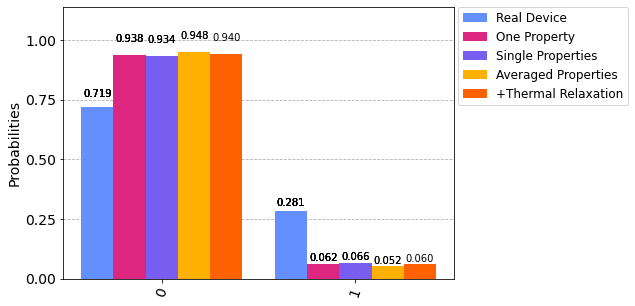

In [33]:
# Plot results with legend
legend = ['Real Device', 'One Property', 'Single Properties','Averaged Properties', '+Thermal Relaxation']
plot_histogram([dct2, counts1, counts2 , counts3 , counts4], legend=legend)#.savefig("/Users/rgomezlu/Google_Drive/Màster/TFM/Programació/Plots/Prova.png")



In [34]:
pe1 = getProbabilities(counts1,1024)
pe2 = getProbabilities(counts2,1024)
pe3 = getProbabilities(counts3,1024)
pe4 = getProbabilities(counts4,1024)
PS = [pe1,pe2,pe3,pe4]
path = "/Users/rgomezlu/Google_Drive/Màster/TFM/Programació/jobs/yorktown/Tele/bar-chart.csv"
data = pd.read_csv("/Users/rgomezlu/Google_Drive/Màster/TFM/Programació/jobs/yorktown/Tele/bar-chart.csv")
#path = "/Users/rgomezlu/Google_Drive/Màster/TFM/Programació/jobs/belem/bar-chart.csv"
#data = pd.read_csv("/Users/rgomezlu/Google_Drive/Màster/TFM/Programació/jobs/belem/bar-chart.csv")

keys = ['0 0 0', '0 0 1', '0 1 0', '0 1 1', '1 0 0', '1 0 1', '1 1 0', '1 1 1']
values = data["Frequency"]

dct = dict(zip(keys,values))

pee = getProbabilities(dct,1024)
print(hellingerDistance(pee,pe4))
h=[]
for x in PS:
    h.append(hellingerDistance(pee,x))
print(h)

KeyError: '0 0 0'

In [ ]:
pe1 = getProbabilities2(counts1,1024)
pe2 = getProbabilities2(counts2,1024)
pe3 = getProbabilities2(counts3,1024)
pe4 = getProbabilities2(counts4,1024)
PS = [pe1,pe2,pe3,pe4]
path = "/Users/rgomezlu/Google_Drive/Màster/TFM/Programació/jobs/yorktown/Tele/bar-chart.csv"
data = pd.read_csv("/Users/rgomezlu/Google_Drive/Màster/TFM/Programació/jobs/yorktown/Tele/bar-chart.csv")

#path = "/Users/rgomezlu/Google_Drive/Màster/TFM/Programació/jobs/belem/Tele/bar-chart-2.csv"
#data = pd.read_csv("/Users/rgomezlu/Google_Drive/Màster/TFM/Programació/jobs/belem/bar-chart-2.csv")

keys = ['0 0 0', '0 0 1', '0 1 0', '0 1 1', '1 0 0', '1 0 1', '1 1 0', '1 1 1']
values = data["Frequency"]
v0 =sum(data["Frequency"][:4])
v1 =sum(data["Frequency"][4:])
valuesT =[v0,v1]
keys2 = ['0','1']
dct = dict(zip(keys,values))
dct2 = dict(zip(keys2,valuesT))
print(dct2)


pee = getProbabilities(dct,1024)
pee1=[sum(pee[:4]),sum(pee[4:])]
print(pee1)
print(hellingerDistance(pee1,pe4))
h=[]
for x in PS:
    h.append(hellingerDistance(pee1,x))
print(h)

In [ ]:
# Plot results with legend
legend = ['Real Device', 'One Property', 'Different Properties', 'Combining Errors', 'Averaged Errors']
plot_histogram([dct2, counts1, counts2 , counts3 , counts4], legend=legend)

In [ ]:
pe1 = getProbabilities(counts1,1024)
pe2 = getProbabilities(counts2,1024)
pe3 = getProbabilities(counts3,1024)
pe4 = getProbabilities(counts4,1024)
PS = [pe1,pe2,pe3,pe4]
#path = "/Users/rgomezlu/Google_Drive/Màster/TFM/Programació/jobs/yorktown/bar-chart.csv"
#data = pd.read_csv("/Users/rgomezlu/Google_Drive/Màster/TFM/Programació/jobs/yorktown/bar-chart.csv")
path = "/Users/rgomezlu/Google_Drive/Màster/TFM/Programació/jobs/belem/bar-chart-3.csv"
data = pd.read_csv("/Users/rgomezlu/Google_Drive/Màster/TFM/Programació/jobs/belem/bar-chart-3.csv")

keys = ['0 0 0', '0 0 1', '0 1 0', '0 1 1', '1 0 0', '1 0 1', '1 1 0', '1 1 1']
values = data["Frequency"]

dct = dict(zip(keys,values))

pee = getProbabilities(dct,1024)
print(hellingerDistance(pee,pe4))
h=[]
for x in PS:
    h.append(hellingerDistance(pee,x))
print(h)

In [ ]:
# Plot results with legend
legend = ['Real Device', 'One Property', 'Different Properties', 'Combining Errors', 'Averaged Errors']
plot_histogram([dct, counts1, counts2 , counts3 , counts4], legend=legend)

## 4. Understanding Quantum Teleportation <a id="understanding-qt">

As you have worked with the Quantum Teleportation's implementation, it is time to understand the mathematics behind the protocol.

#### Step 1

Quantum Teleportation begins with the fact that Alice needs to transmit $|\psi\rangle = \alpha|0\rangle + \beta|1\rangle$ (a random qubit) to Bob. She doesn't know the state of the qubit. For this, Alice and Bob take the help of a third party (Telamon). Telamon prepares a pair of entangled qubits for Alice and Bob. The entangled qubits could be written in Dirac Notation as:

$$ |e \rangle = \frac{1}{\sqrt{2}} (|00\rangle + |11\rangle) $$

Alice and Bob each possess one qubit of the entangled pair (denoted as A and B respectively),

$$|e\rangle = \frac{1}{\sqrt{2}} (|0\rangle_A |0\rangle_B + |1\rangle_A |1\rangle_B) $$

This creates a three qubit quantum system where Alice has the first two qubits and Bob the last one.

$$ \begin{align*}
|\psi\rangle \otimes |e\rangle &= \frac{1}{\sqrt{2}} (\alpha |0\rangle \otimes (|00\rangle + |11\rangle) + \beta |1\rangle \otimes (|00\rangle + |11\rangle))\\
&= \frac{1}{\sqrt{2}} (\alpha|000\rangle + \alpha|011\rangle + \beta|100\rangle + \beta|111\rangle) 
\end{align*}$$

#### Step 2

Now according to the protocol Alice applies CNOT gate on her two qubits followed by Hadamard gate on the first qubit. This results in the state:

$$ 
\begin{align*} (H \otimes I \otimes I) (CNOT \otimes I) (|\psi\rangle \otimes |e\rangle)
&=(H \otimes I \otimes I) (CNOT \otimes I) \frac{1}{\sqrt{2}} (\alpha|000\rangle + \alpha|011\rangle + \beta|100\rangle + \beta|111\rangle) \\
&= (H \otimes I \otimes I) \frac{1}{\sqrt{2}} (\alpha|000\rangle + \alpha|011\rangle + \beta|110\rangle + \beta|101\rangle) \\
&= \frac{1}{2}  (\alpha(|000\rangle + |011\rangle + |100\rangle + |111\rangle) + \beta(|010\rangle + |001\rangle - |110\rangle - |101\rangle)) \\
\end{align*}
$$

Which can then be separated and written as: 

$$
\begin{align*}
= \frac{1}{2}(
 & \phantom{+} |00\rangle (\alpha|0\rangle + \beta|1\rangle) \hphantom{\quad )} \\
 & + |01\rangle (\alpha|1\rangle + \beta|0\rangle) \hphantom{\quad )}\\[4pt]
 & + |10\rangle (\alpha|0\rangle - \beta|1\rangle) \hphantom{\quad )}\\[4pt]
 & + |11\rangle (\alpha|1\rangle - \beta|0\rangle) \quad )\\
\end{align*}
$$

#### Step 3

Alice measures the first two qubit (which she owns) and sends them as two classical bits to Bob. The result she obtains is always one of the four standard basis states $|00\rangle, |01\rangle, |10\rangle,$ and $|11\rangle$ with equal probability.  

On the basis of her measurement, Bob's state will be projected to, 
$$ |00\rangle \rightarrow (\alpha|0\rangle + \beta|1\rangle)\\
|01\rangle \rightarrow (\alpha|1\rangle + \beta|0\rangle)\\
|10\rangle \rightarrow (\alpha|0\rangle - \beta|1\rangle)\\
|11\rangle \rightarrow (\alpha|1\rangle - \beta|0\rangle)$$.

#### Step 4

Bob, on receiving the bits from Alice, knows he can obtain the original state $|\psi\rangle$ by applying appropriate transformations on his qubit that was once part of the entangled pair.

The transformations he needs to apply are:

$$
\begin{array}{c c c}
\mbox{Bob's State}                 & \mbox{Bits Received} & \mbox{Gate Applied} \\
(\alpha|0\rangle + \beta|1\rangle) & 00                   & I                   \\
(\alpha|1\rangle + \beta|0\rangle) & 01                   & X                   \\
(\alpha|0\rangle - \beta|1\rangle) & 10                   & Z                   \\
(\alpha|1\rangle - \beta|0\rangle) & 11                   & ZX
\end{array}
$$

After this step Bob will have successfully reconstructed Alice's state.

## 5. Teleportation on a Real Quantum Computer <a id='real_qc'></a>

### 5.1 IBM hardware and Deferred Measurement <a id='deferred-measurement'></a>

The IBM quantum computers currently do not support instructions after measurements, meaning we cannot run the quantum teleportation in its current form on real hardware. Fortunately, this does not limit our ability to perform any computations due to the _deferred measurement principle_ discussed in chapter 4.4 of [1]. The principle states that any measurement can be postponed until the end of the circuit, i.e. we can move all the measurements to the end, and we should see the same results.

![deferred_measurement_gates](images/defer_measurement.svg)

Any benefits of measuring early are hardware related: If we can measure early, we may be able to reuse qubits, or reduce the amount of time our qubits are in their fragile superposition. In this example, the early measurement in quantum teleportation would have allowed us to transmit a qubit state without a direct quantum communication channel.

While moving the gates allows us to demonstrate the "teleportation" circuit on real hardware, it should be noted that the benefit of the teleportation process (transferring quantum states via classical channels) is lost.

Let us re-write the `bob_gates` function to `new_bob_gates`:

In [ ]:
def new_bob_gates(qc, a, b, c):
    qc.cx(b, c)
    qc.cz(a, c)

And create our new circuit:

In [ ]:
qc = QuantumCircuit(3,3)

# First, let's initialize Alice's q0
qc.append(init_gate, [0])
qc.barrier()

# Now begins the teleportation protocol
create_bell_pair(qc, 1, 2)
qc.barrier()
# Send q1 to Alice and q2 to Bob
alice_gates(qc, 0, 1)
qc.barrier()
# Alice sends classical bits to Bob
new_bob_gates(qc, 0, 1, 2)

# We undo the initialization process
qc.append(inverse_init_gate, [2])

# See the results, we only care about the state of qubit 2
qc.measure(2,2)
qc.measure(0,0)
qc.measure(1,1)
# View the results:
qc.draw()

### 5.2 Executing <a id='executing'></a> 

In [ ]:
# get the least-busy backend at IBM and run the quantum circuit there
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
backend = least_busy(provider.backends(filters=lambda b: b.configuration().n_qubits >= 3 and
                                   not b.configuration().simulator and b.status().operational==True))
backend = provider.backend.ibmq_16_melbourne
#experiment = execute(qc, backend, shots=1024).result()
#t_qc = transpile(qc, backend, optimization_level=3)
#qobj = assemble(t_qc)
#job = backend.run(qobj)
#job_monitor(job)  # displays job status under cell

In [ ]:
# Get the results and display them
exp_result = job.result()
exp_counts = experiment.get_counts(qc)
print(exp_counts)
plot_histogram(exp_counts)

As we see here, there are a few results in which we measured $|1\rangle$. These arise due to errors in the gates and the qubits. In contrast, our simulator in the earlier part of the notebook had zero errors in its gates, and allowed error-free teleportation.

In [ ]:
print(f"The experimental error rate : {exp_counts['1']/sum(exp_counts.values()):.3f}%")

## 6. References <a id='references'></a>
[1] M. Nielsen and I. Chuang, Quantum Computation and Quantum Information, Cambridge Series on Information and the Natural Sciences (Cambridge University Press, Cambridge, 2000).

[2] Eleanor Rieffel and Wolfgang Polak, Quantum Computing: a Gentle Introduction (The MIT Press Cambridge England, Massachusetts, 2011).

In [ ]:
import qiskit
qiskit.__qiskit_version__